This notebook shows building a recommendation system using ALS algorithm on MovieLens Dataset. The algorithm is demonstrated in Harper and Konstan's 2015 paper. The notebook implements ALS algorithm through both its primitive way and the use of MLlib way. Finally, the algorithm returns a list of top N recommended movies and their ratings to each input user. 

Reference: 
1. (Spark ML library) https://spark.apache.org/docs/2.1.0/api/python/pyspark.ml.html
2. F. Maxwell Harper, Joseph A. Konstan. 2015. The Movie Lens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems, December 2015. DOI = https://dx.doi.org/10.1145/2827872

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [2]:
import os
import findspark
os.environ["PYSPARK_PYTHON"] = "python3"
findspark.init("../../spark-2.2.0-bin-hadoop2.7",)

In [3]:
from pyspark.sql import SparkSession, Column, Row, functions as F 
spark = (
    SparkSession.builder
        .master("local[*]")
        .appName("ALS algorithm")
        .getOrCreate()
)
sc = spark.sparkContext

In [4]:
movies = spark.read.load("../data/ml-latest-small/movies.csv", format='csv', header = True)
ratings = spark.read.load("../data/ml-latest-small/ratings.csv", format='csv', header = True)
links = spark.read.load("../data/ml-latest-small/links.csv",format='csv', header = True)
tags = spark.read.load("../data/ml-latest-small/tags.csv",format='csv', header = True)

In [5]:
ratings.show(5)

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|     31|   2.5|1260759144|
|     1|   1029|   3.0|1260759179|
|     1|   1061|   3.0|1260759182|
|     1|   1129|   2.0|1260759185|
|     1|   1172|   4.0|1260759205|
+------+-------+------+----------+
only showing top 5 rows



In [6]:
# convert types
ratings = ratings.select(ratings.userId.cast("integer"), 
                        ratings.movieId.cast("integer"),
                        ratings.rating.cast("float")) 

## Plain ALS

In [144]:
'''
The function performs ALS based on its principle. It alternatively updates two decomposed 
matrices until the their multiplication approximates original matrix.
@param alpha regularization factor
@param num number of factors
@param matrix input rating matrix
@param number of iterations 
'''
def plain_ALS(alpha, num, matrix, iterations):
    # initialize matrices
    N = 5
    X = N * np.random.rand(matrix.shape[0], num)
    Y = N * np.random.rand(num, matrix.shape[1])
    errors = []
    for i in range(iterations):
        X = np.linalg.solve(np.dot(Y, Y.T) + alpha * np.eye(num), np.dot(Y, matrix.T)).T
        Y = np.linalg.solve(np.dot(X.T, X) + alpha * np.eye(num), np.dot(X.T, matrix))
        err = np.square(np.dot(X, Y) - matrix ).mean()[0]
        errors.append(err)
        if i % 3 == 0:
            print (X.shape)
            print (Y.shape)
            print("The ", i ,"th iteration has training error", err)
    approx_matrix = np.dot(X, Y)
    plt.plot(errors, ".")
    return errors   

(100004, 30)
(30, 3)
The  0 th iteration has training error 2.10940032352e-06
(100004, 30)
(30, 3)
The  3 th iteration has training error 2.0822054808e-06
(100004, 30)
(30, 3)
The  6 th iteration has training error 2.05487238441e-06
(100004, 30)
(30, 3)
The  9 th iteration has training error 2.02733683037e-06
(100004, 30)
(30, 3)
The  12 th iteration has training error 1.99949749401e-06


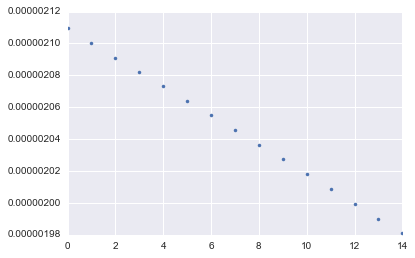

In [145]:
e = plain_ALS(1.5, 30, ratings.toPandas(), 15)

We can also use Spark ML libary to achieve ALS, which also enables us to perform hyperparameter tuning and recommendation more easily. 

## Build ALS Model Using MLlib

In [7]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder, CrossValidator
from pyspark.mllib.recommendation import MatrixFactorizationModel, Rating

In [8]:
(train_data, test_data) = ratings.randomSplit([0.8,0.2], seed = 42)

In [9]:
train_data.cache()
test_data.cache()

DataFrame[userId: int, movieId: int, rating: float]

In [37]:
# Define the model
# Set Colde Start Stratgy false in case we run into users we have no data before
ALS_model = ALS(userCol = "userId", itemCol = "movieId", ratingCol = "rating", seed= 245, nonnegative= True, 
                coldStartStrategy="drop")

In [38]:
# We define grid search algorithm similar to GridSearchCV 
# using ParamBuilder
model = ALS_model
search_grid = ParamGridBuilder().addGrid(model.rank, [9,10,11,12])\
                .addGrid(model.maxIter, [17])\
                .addGrid(model.regParam, [0.18, 0.2, 0.22])\
                .build()
# We define loss function to be root mean square error
loss_eval = RegressionEvaluator(metricName = "rmse", labelCol = "rating", predictionCol = "prediction")                

In [39]:
# Define Cross Validator
# The default will use 3 folds cross_validation 
cv_estimator = CrossValidator(
                estimator = model,
                estimatorParamMaps = search_grid,
                evaluator = loss_eval)

In [40]:
# fit models. Return a set of models 4 x 3 x 3 = 36 models
cv_model = cv_estimator.fit(train_data)

In [41]:
best_model = cv_model.bestModel
predictions  = best_model.transform(test_data)
error = loss_eval.evaluate(predictions)

In [42]:
print("The mean square error is: ", error)
print("The best model has rank: ", best_model.rank, ". MaxIter: ", best_model._java_obj.parent().getMaxIter())
print("The model has regularization parameter: ", best_model._java_obj.parent().getRegParam())

The mean square error is:  0.90020456948439
The best model has rank:  9 . MaxIter:  17
The model has regularization parameter:  0.18


In [62]:
# Save model 
import os, tempfile
#path = tempfile.mkdtemp()
best_model.save("../model/best_model")
#nnn = ALS.load("../model/best_model")

## Recommendation

In [48]:
# actual rating v.s predicted rating in test set for user 1
predictions.sort("userId", "rating").show(5)

+------+-------+------+----------+
|userId|movieId|rating|prediction|
+------+-------+------+----------+
|     1|   2294|   2.0| 2.1083632|
|     1|   1129|   2.0| 2.0693965|
|     1|   1029|   3.0| 2.3426754|
|     1|   1061|   3.0| 2.3465362|
|     1|   2105|   4.0| 1.9532092|
+------+-------+------+----------+
only showing top 5 rows



In [66]:
# Generate top N movies for each user based on predicted rating
N = 5
user_recs = best_model.recommendForAllUsers(N)

In [68]:
user_recs.show(10)

+------+--------------------+
|userId|     recommendations|
+------+--------------------+
|   471|[[83318,5.1466894...|
|   463|[[83318,5.098796]...|
|   496|[[59684,5.426467]...|
|   148|[[83318,5.8606596...|
|   540|[[73290,5.7574763...|
|   392|[[3216,4.855725],...|
|   243|[[83318,5.0760756...|
|   623|[[83318,5.6917357...|
|    31|[[83318,5.6117496...|
|   516|[[83318,5.0901046...|
+------+--------------------+
only showing top 10 rows



**Note:**
The column 'recommendations' is in a special format where it wraps up movieId and rating etc. information. Therefore, it would be more readable if we properly expand this column.  

In [70]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [102]:
def convert(df):
    movieId = df.select("userId","recommendations.movieId").toPandas()
    ratings = df.select("recommendations.rating").toPandas().round(2)
    new_df = pd.DataFrame(movieId, columns=["userId", "movieId"])
    new_df['rating'] = ratings
    new_sp_df = sqlContext.createDataFrame(new_df)
    return new_sp_df

In [103]:
new_user_recs = convert(user_recs)
#user_recs.select("recommendations.movieId", "recommendations.rating").toPandas()

In [104]:
new_user_recs.show(10)

+------+--------------------+--------------------+
|userId|             movieId|              rating|
+------+--------------------+--------------------+
|   471|[83318, 67504, 83...|[5.14668941497802...|
|   463|[83318, 83411, 67...|[5.09879589080810...|
|   496|[59684, 31435, 10...|[5.42646694183349...|
|   148|[83318, 83411, 67...|[5.86065959930419...|
|   540|[73290, 80839, 41...|[5.75747632980346...|
|   392|[3216, 92494, 979...|[4.85572481155395...|
|   243|[83318, 67504, 83...|[5.07607555389404...|
|   623|[83318, 67504, 83...|[5.69173574447631...|
|    31|[83318, 83411, 67...|[5.61174964904785...|
|   516|[83318, 67504, 83...|[5.09010457992553...|
+------+--------------------+--------------------+
only showing top 10 rows

